In [1]:
import numpy as np
import pandas as pd
from sail.pipeline import SAILPipeline
from sail.models.keras import KerasSequentialClassifier
from sklearn.impute import SimpleImputer
from sail.transformers.river.preprocessing import StandardScaler

#### Load Data


In [2]:
X = pd.read_csv("../datasets/agrawal.csv").head(5000)

y = X["class"]
X.drop("class", axis=1, inplace=True)

#### Model Definition


In [3]:
model = KerasSequentialClassifier(
    num_hidden_nodes= 8,
    hidden_layer_activation= "relu",
    num_output_nodes= 1,
    outer_layer_activation="sigmoid"
)

#### Create SAIL Pipeline


In [4]:
steps = [
    ("Imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ("standard_scalar", StandardScaler()),
    ("classifier", model),
]
sail_pipeline = SAILPipeline(steps=steps, scoring="Accuracy", verbosity_level=1, verbosity_interval=50)

#### Start Incremental Training


In [5]:
y_preds = []
y_true = []
batch_size = 5
for start in range(0, 2000, batch_size):

    end = start + batch_size

    Xt = X.iloc[start:end]
    yt = y.iloc[start:end]

    if start != 0 :
        preds = sail_pipeline.predict(Xt)
        y_preds.extend(list(preds))
        y_true.extend(list(yt))
    
    sail_pipeline.partial_fit(Xt, yt)


    
>> Epoch: 1 | Samples Seen: 0 -------------------------------------------------------------------------------------
SAIL Pipeline Partial fit [classifier]:  67%======     [Steps: 2/3, ETA: 00:00<00:00, Elapsed:0.010s, Batch Size=5]     2023-10-03 21:59:00.398933: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
SAIL Pipeline Partial fit: 100%========== [Steps: 3/3, ETA: 00:00<00:00, Elapsed:0.383s, Batch Size=5, P_Score=0]             

    
>> Epoch: 50 | Samples Seen: 245 -------------------------------------------------------------------------------------
SAIL Pipeline Partial fit: 100%========== [Steps: 3/3, ETA: 00:00<00:00, Elapsed:0.038s, Batch Size=5, P_Score=0.396]             

    
>> Epoch: 100 | Samples Seen: 495 -------------------------------------------------------------------------------------
SAIL Pipeline Partial fit: 100%========== [Steps: 3/3, ETA: 00:00<00:00, Elapsed:0.167s, Batch Size=5, P_Score=0.44]             

#### Final Score


In [6]:
sail_pipeline.get_progressive_score

0.5203007518796993

              precision    recall  f1-score   support

           0       0.67      0.55      0.60      1317
           1       0.35      0.46      0.40       678

    accuracy                           0.52      1995
   macro avg       0.51      0.51      0.50      1995
weighted avg       0.56      0.52      0.53      1995



<Axes: >

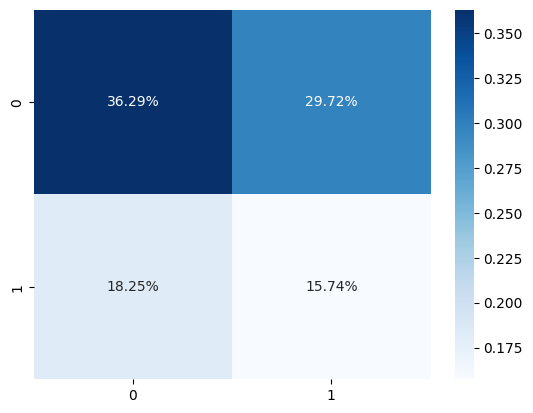

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_true, y_preds))
cf_matrix = confusion_matrix(y_true, y_preds)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')